# **Insper - Eletromagnetismo e Ondulatória** #


**Repelente elétrico acionado por transmissão de energia sem fio**

Desenvolvido por: 
- Caue Pileckas D Agostinho
- Enzo Davi Ribeiro Barroso da Silva
- Gabrielly Carneiro Susko 
- Venâncio Freitas de Araujo Filho


# 1. Simulação

Para a primeira etapa de simulação, foram esquematizados dois circuitos:

1. Capacitor do secundário em paralelo com a carga
2. Capacitor do secundário em série com a carga

O objetivo final da simulação é escolher a configuração (série ou paralelo), o valor de capacitância e o valor de frequência mais adequados ao funcionamento do circuito.

<div style="text-align: center;">
    <img src="circuitoParalelo.png"/>
    <p>Circuito 1 - Capacitor em paralelo.</p>
</div>

<div style="text-align: center;">
    <img src="circuitoSerie.png"/>
    <p>Circuito 2 - Capacitor em série.</p>
</div>

##### 1.1 Ferramentas utilizadas para a simulação

Para simular o circuito real utilizado, foram utilizadas as bibliotecas e funções definidas abaixo:

> Módulos necessários

In [421]:
from cmath import *
from numpy import linalg
import numpy as np
import matplotlib.pyplot as plt

> Funções necessárias para cálculo dos valores dos componentes

In [422]:
# Função responsável por calcular a indutância de um indutor de núcleo
# de ar a partir da frequência de ressonância e do capacitor associado
def indutancia_ressonante(f, C):
    return 1/(4*pi**2*f**2*C)

# Função que calcula as impedâncias dos componentes de um circuito RLC
def impedancia(R, C, L, f):
    omega = 2 * np.pi * f
    Zc = 1/(1j*omega*C) # Impedância do capacitor
    Zl = 1j*omega*L # Impedância do indutor
    Zr = R # Impedância do resistor
    return Zc, Zl, Zr

#Função que calcula a impedância de um indutor mútuo
def impedancia_ZM(L1, L2, K, freq):
    omega = 2 * np.pi * freq
    M = K * np.sqrt(L1*L2)
    Zm = 1j*omega*M
    return Zm

# Função que calcula a impedância de um capacitor de placas paralelas
def R_pelicular (Rdc, f):
    Rf = Rdc + (Rdc/(100*10**3))*f
    return Rf, Rf

> Funções necessárias para cálculo dos valores de corrente, tensão, potência e eficiência relativos aos circuitos 1 e 2.

In [423]:
# Função responsável pelo cálculo do circuito 1 - capacitor em paralelo
def CalcularTransformadorCapacitorParalelo(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf):
    # Cálculo da impedância total
    Z = np.array([[ZR1 + ZL1 + ZC1, -ZM], 
                  [-ZM, ZR2 + ZL2 + ((ZC2*Rc)/(ZC2+Rc))]]) 
    
    V = np.array([Uf, 0])
    I = np.dot(linalg.inv(Z), V)  # Cálculo da corrente
    
    i1 = I[0]
    i2 = I[1]
    Zeq = Rc*ZC2/(Rc + ZC2)
    V2 = Zeq*i2   #tensao na saída

    # Potência de entrada (no primário)
    P_entrada = np.real(0.5*Uf * np.conj(i1))
    # Potência de saída (no secundário)
    P_saida = np.real(0.5* V2 * np.conj(i2))
    
    eficiencia = 100*P_saida/P_entrada if P_entrada > 0 else 0
    
    v2_abs = abs(V2)
    P_resistor = v2_abs**2/(2*Rc)

    return i1, i2, v2_abs, eficiencia, P_resistor
   
# Função responsável pelo cálculo do circuito 2 - capacitor em série 
def CalcularTransformadorCapacitorSerie(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf):
    # Cálculo da impedância total
    Z = np.array([[ZR1 + ZL1 + ZC1, -ZM], 
                  [-ZM, ZR2 + ZL2 + ZC2 + Rc]])  
    
    V = np.array([Uf, 0])
    I = np.dot(linalg.inv(Z), V)  # Cálculo da corrente
    
    i1 = I[0]
    i2 = I[1]
    
    V2 = Rc*i2  #tensao na saída
    
    #potencias
    # Potência de entrada (no primário)
    P_entrada = np.real(0.5*Uf * np.conj(i1))
    
    # Potência de saída (no secundário)
    P_saida = np.real(0.5* V2 * np.conj(i2))
    
    eficiencia = 100*P_saida/P_entrada if P_entrada != 0 else 0
    
    v2_abs = abs(V2)
    P_resistor = v2_abs**2/(2*Rc)

    return i1, i2, v2_abs, eficiencia, P_resistor

##### 1.2 Valores utilizados para a simulação

Para a simulaçao foram estimados valores razoáveis do ponto de vista físico, mas sem relaçao direta com os valores finais utilizados no projeto.



In [424]:
frequencias = np.linspace(1, 100e3, 1500) #lista com frequências de 1Hz a 100kHz
valores_c2 = [150e-9, 0.1e-6, 0.47e-6, 1e-6, 4.7e-6] #valores de capacitância para C2 disponíveis para utilização no projeto
Uf = (2/pi)*12    # Tensão de entrada (V1)
Rc = 5     # Resistência de carga (R_C)
K = 0.2    # Coeficiente de acoplamento
Rdc = 0.2  # Resistência de cobre no primário e secundário

##### 1.3 Gráficos gerados a partir da simulação

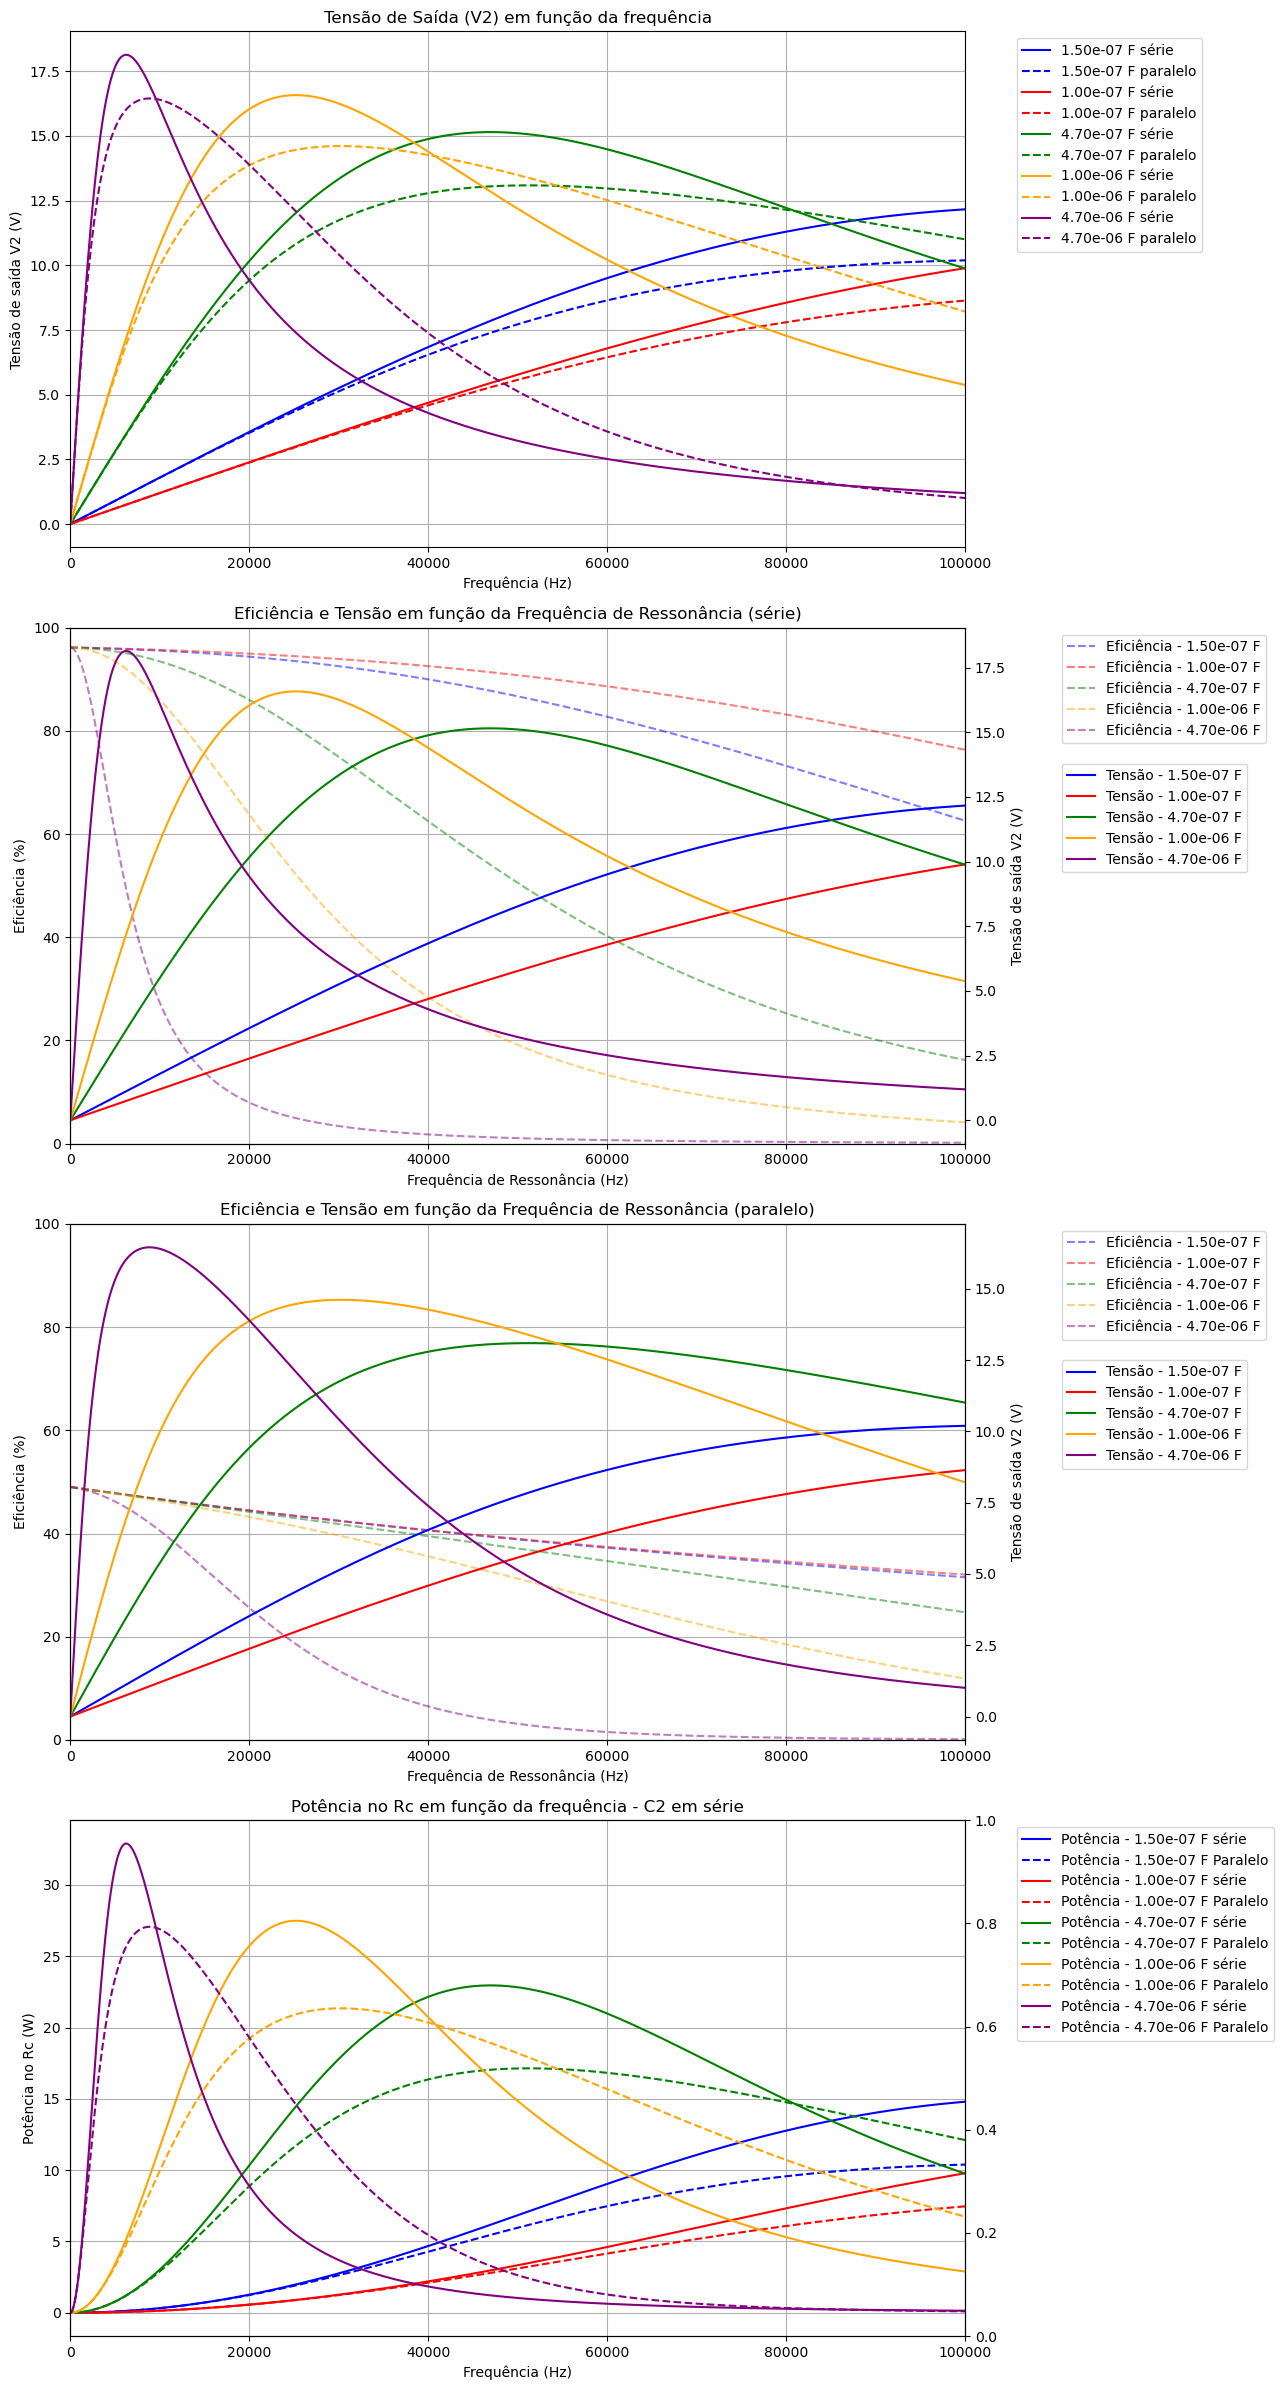

In [425]:
# Definição do estilo dos gráficos
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13, 24))
cores = ['b', 'r', 'g', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'lime']
linestyles = ['-', '--','-.']

ax2_twin = ax2.twinx()
ax3_twin = ax3.twinx()
ax4_twin = ax4.twinx()

# Loop para calcular e plotar os gráficos, considerando cada valor de C2
for i, C in enumerate(valores_c2):
    V_serie = []
    V_paralelo = []
    ef_serie = []
    ef_paralelo = []
    P_res_serie = []
    P_res_paralelo = []
    
    # Loop considerando cada valor de frequencia
    for freq in frequencias:
        #calculo dos componentes
        L1 = indutancia_ressonante(freq, C)
        L2 = indutancia_ressonante(freq, C)
        R1, R2 = R_pelicular(Rdc, freq)
        ZC1, ZL1, ZR1 = impedancia(R1, C, L1, freq)
        ZC2, ZL2, ZR2 = impedancia(R2, C, L2, freq)
        ZM = impedancia_ZM(L1, L2, K, freq)
        
        # Calcular para paralelo
        i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorParalelo(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
        V_paralelo.append(V2)
        ef_paralelo.append(eficiencia)
        P_res_paralelo.append(P_res)
        
        # Calcular para série
        i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorSerie(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
        V_serie.append(V2)
        ef_serie.append(eficiencia)
        P_res_serie.append(P_res)
    
    # Plotar tensão série e paralelo no primeiro gráfico (ax1)
    ax1.plot(frequencias, V_serie, label=f'{C:.2e} F série', color=cores[i], linestyle=linestyles[0])
    ax1.plot(frequencias, V_paralelo, label=f'{C:.2e} F paralelo', color=cores[i], linestyle=linestyles[1]) 

    # Plotar eficiência de serie no segundo gráfico (ax2)
    ax2.plot(frequencias, ef_serie, label=f'Eficiência - {C:.2e} F', color=cores[i], linestyle=linestyles[1], alpha=0.5)
    ax2_twin.plot(frequencias, V_serie, label=f'Tensão - {C:.2e} F', color=cores[i], linestyle=linestyles[0])
    
    # Plotar eficiência de paralelo no terceiro gráfico (ax3)
    ax3.plot(frequencias, ef_paralelo, label=f'Eficiência - {C:.2e} F', color=cores[i], linestyle=linestyles[1], alpha=0.5)
    ax3_twin.plot(frequencias, V_paralelo, label=f'Tensão - {C:.2e} F', color=cores[i], linestyle=linestyles[0])
    
    #plotando potencia
    ax4.plot(frequencias, P_res_serie, label=f'Potência - {C:.2e} F série', color=cores[i], linestyle=linestyles[0])
    ax4.plot(frequencias, P_res_paralelo, label=f'Potência - {C:.2e} F Paralelo', color=cores[i], linestyle=linestyles[1])
    # ax4_twin.plot(frequencias, ef_serie, label=f'{C:.2e} F serie', color=cores[i], linestyle=linestyles[2], alpha=0.5)
    

# Configurações do gráfico de tensões (ax1)
ax1.set_title("Tensão de Saída (V2) em função da frequência")
ax1.set_xlabel("Frequência (Hz)")
ax1.set_ylabel("Tensão de saída V2 (V)")
ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax1.set_xlim(0, 100e3)  # Limite dos valores de frequêcia é até 100kHz
ax1.grid(True)

# Configurações do gráfico de eficiência (ax2)
ax2.set_title("Eficiência e Tensão em função da Frequência de Ressonância (série)")
ax2.set_xlabel("Frequência de Ressonância (Hz)")
ax2.set_ylabel("Eficiência (%)")
ax2.legend(loc="upper left", bbox_to_anchor=(1.1, 1))
ax2.set_xlim(0, 100e3)
ax2.set_ylim(0, 100)
ax2.grid(True)

# Adicionar a legenda para o eixo secundário (twinx) do ax2
ax2_twin.set_ylabel("Tensão de saída V2 (V)")
ax2_twin.legend(loc="upper left", bbox_to_anchor=(1.1, 0.75))  # Legenda do twin

# Configurações do gráfico de eficiência (ax3)
ax3.set_title("Eficiência e Tensão em função da Frequência de Ressonância (paralelo)")
ax3.set_xlabel("Frequência de Ressonância (Hz)")
ax3.set_ylabel("Eficiência (%)")
ax3.legend(loc="upper left", bbox_to_anchor=(1.1, 1))
ax3.set_xlim(0, 100e3)
ax3.set_ylim(0, 100)
ax3.grid(True)

# Adicionar a legenda para o eixo secundário (twinx) do ax3
ax3_twin.set_ylabel("Tensão de saída V2 (V)")
ax3_twin.legend(loc="upper left", bbox_to_anchor=(1.1, 0.75))  # Legenda do twin

ax4.set_title("Potência no Rc em função da frequência - C2 em série")
ax4.set_xlabel("Frequência (Hz)")
ax4.set_ylabel("Potência no Rc (W)")
ax4.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax4.set_xlim(0, 100e3)
ax4.grid(True)


# ax4_twin.set_ylabel("eficiencia (%)")
# ax4_twin.legend(loc="upper left", bbox_to_anchor=(1.1, 0.75))  # Legenda do twin

# Ajustar layout para não sobrepor elementos
plt.tight_layout()

# Exibir gráfico
plt.show()


In [426]:
frequencias = np.linspace(1, 140e3, 1500)
valores_c2 = [0.47e-6, 1e-6]
Rc = 5    # Resistência de carga (R_C)
K = 0.2  # Coeficiente de acoplamento
Rdc = 0.2  # Resistência de cobre no primário e secundário

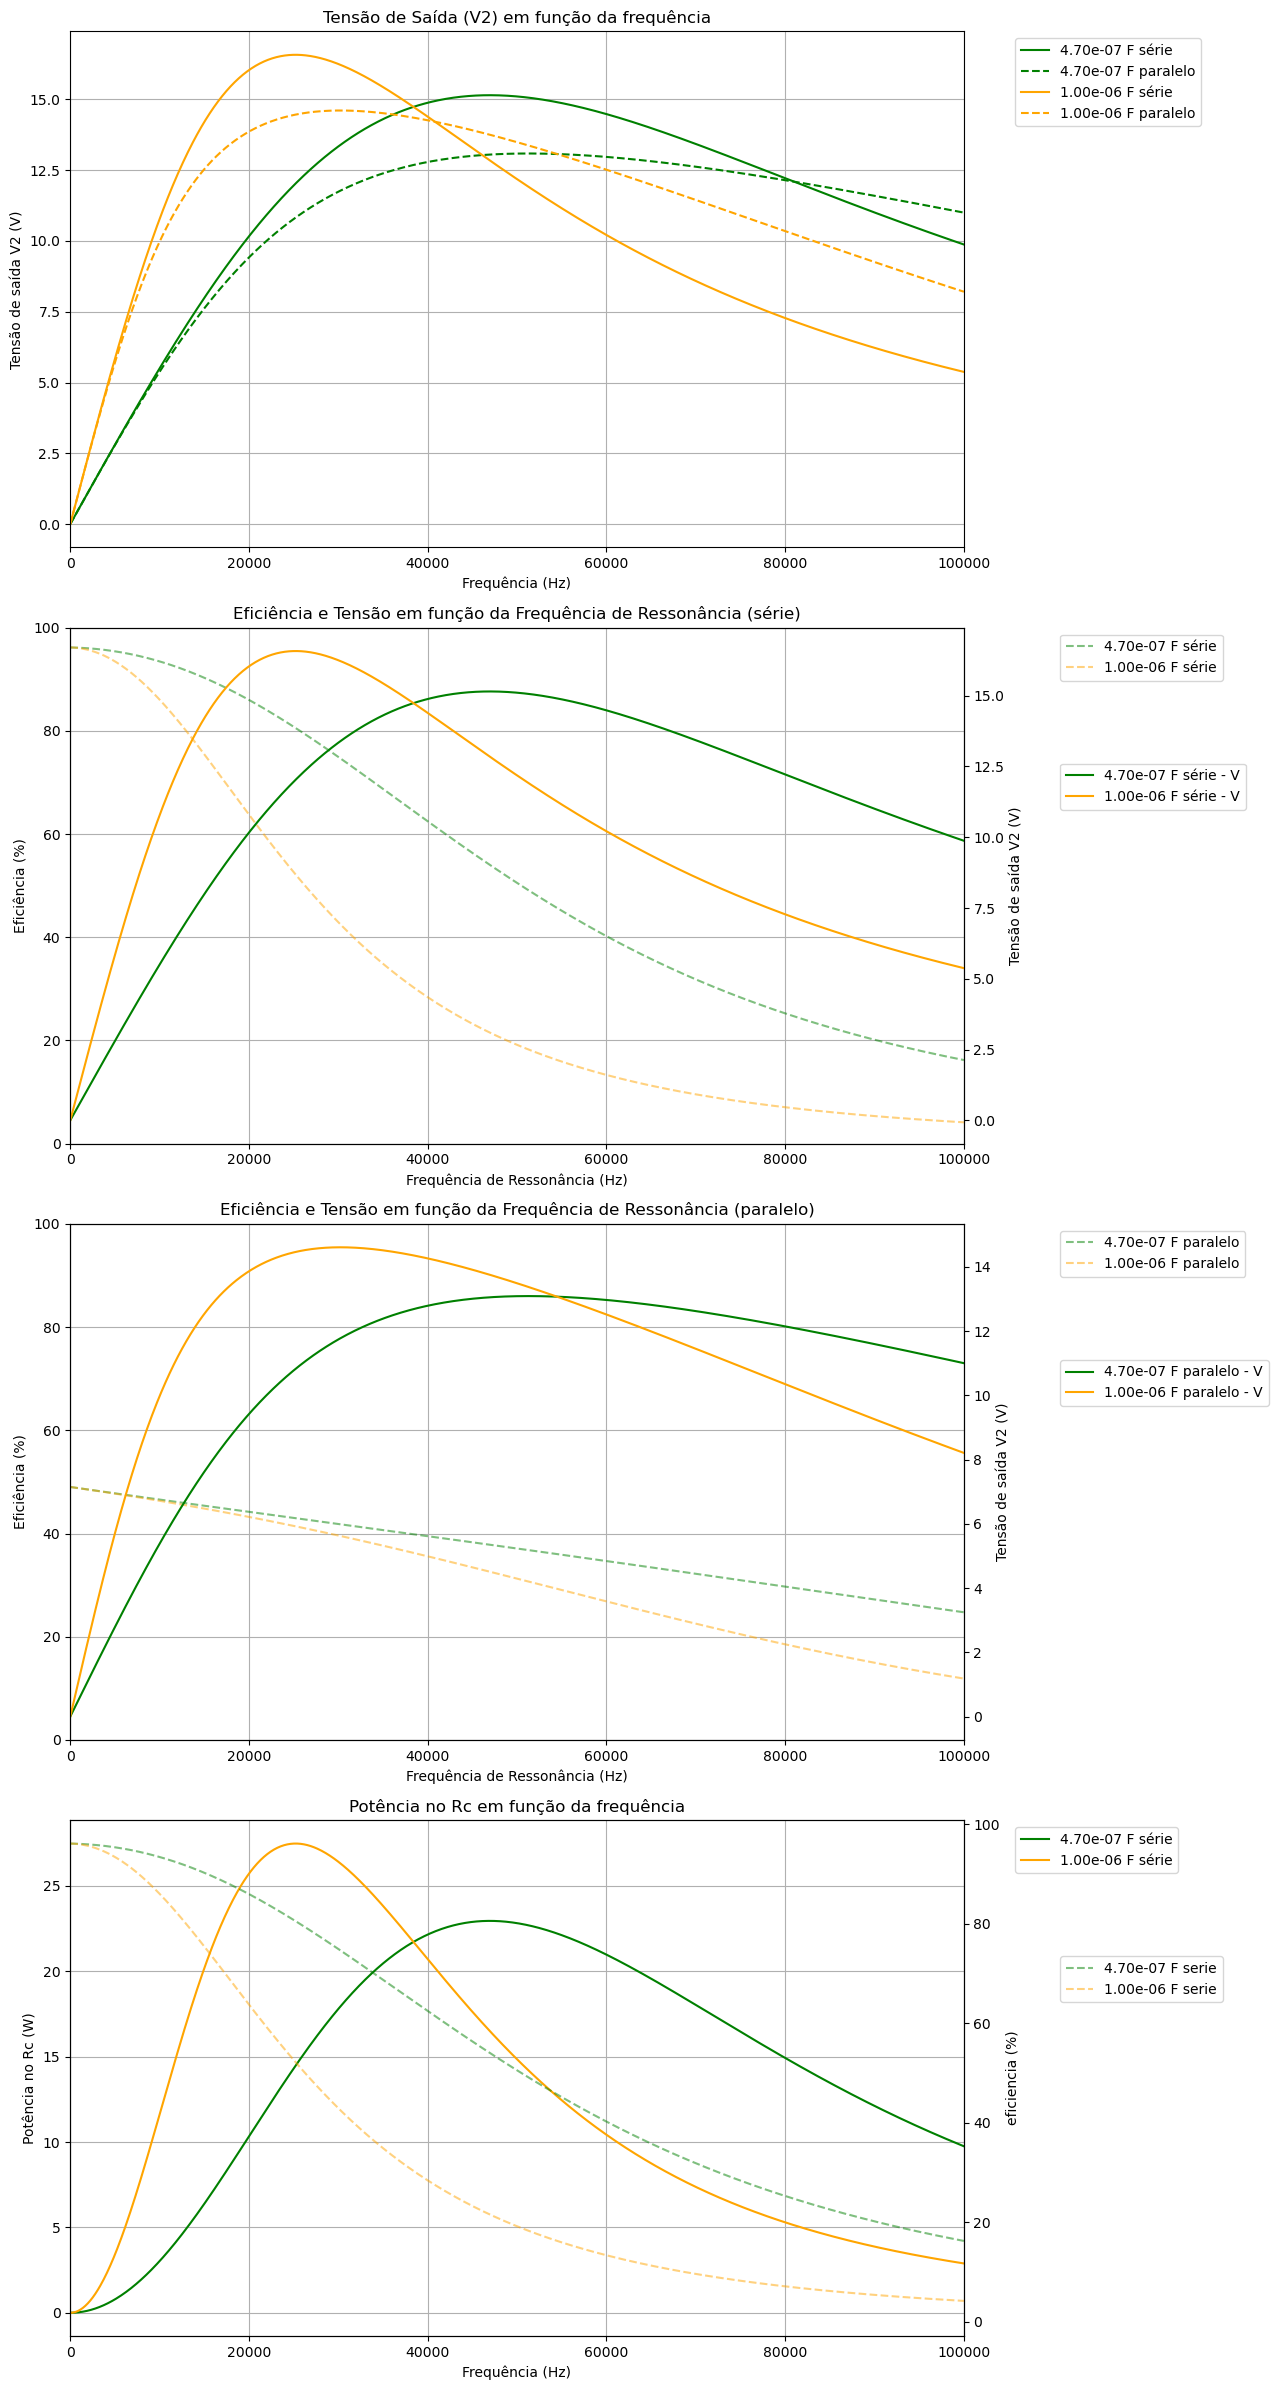

In [427]:
# Criar uma figura com três subplots verticais
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13, 24))

cores = [ 'g',    'orange' ]

linestyles = ['-', '--']

ax2_twin = ax2.twinx()
ax3_twin = ax3.twinx()
ax4_twin = ax4.twinx()

for i, C in enumerate(valores_c2):
    V_serie = []
    V_paralelo = []
    ef_serie = []
    ef_paralelo = []
    P_res_serie = []
    P_res_paralelo = []
    
    for freq in frequencias:
        L1 = indutancia_ressonante(freq, C)
        L2 = indutancia_ressonante(freq, C)
        R1, R2 = R_pelicular(Rdc, freq)
        ZC1, ZL1, ZR1 = impedancia(R1, C, L1, freq)
        ZC2, ZL2, ZR2 = impedancia(R2, C, L2, freq)
        ZM = impedancia_ZM(L1, L2, K, freq)
        Uf = (2/pi)*12
        #Uf = 6
        # Calcular para paralelo
        i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorParalelo(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
        V_paralelo.append(V2)
        ef_paralelo.append(eficiencia)
        P_res_paralelo.append(P_res)
        
        # Calcular para série
        i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorSerie(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
        V_serie.append(V2)
        ef_serie.append(eficiencia)
        P_res_serie.append(P_res)
    
    # Plotar tensão série e paralelo no primeiro gráfico (ax1)
    ax1.plot(frequencias, V_serie, label=f'{C:.2e} F série', color=cores[i], linestyle=linestyles[0])
    ax1.plot(frequencias, V_paralelo, label=f'{C:.2e} F paralelo', color=cores[i], linestyle=linestyles[1]) 

    # Plotar eficiência de serie no segundo gráfico (ax2)
    ax2.plot(frequencias, ef_serie, label=f'{C:.2e} F série', color=cores[i], linestyle=linestyles[1], alpha=0.5)
    ax2_twin.plot(frequencias, V_serie, label=f'{C:.2e} F série - V', color=cores[i], linestyle=linestyles[0])
    
    # Plotar eficiência de paralelo no terceiro gráfico (ax3)
    ax3.plot(frequencias, ef_paralelo, label=f'{C:.2e} F paralelo', color=cores[i], linestyle=linestyles[1], alpha=0.5)
    ax3_twin.plot(frequencias, V_paralelo, label=f'{C:.2e} F paralelo - V', color=cores[i], linestyle=linestyles[0])
    
    #plotando potencia
    ax4.plot(frequencias, P_res_serie, label=f'{C:.2e} F série', color=cores[i], linestyle=linestyles[0])
    # ax4.plot(frequencias, P_res_paralelo, label=f'{C:.2e} F paralelo', color=cores[i], linestyle=linestyles[0])
    ax4_twin.plot(frequencias, ef_serie, label=f'{C:.2e} F serie', color=cores[i], linestyle=linestyles[1], alpha=0.5)
    

# Configurações do gráfico de tensões (ax1)
ax1.set_title("Tensão de Saída (V2) em função da frequência")
ax1.set_xlabel("Frequência (Hz)")
ax1.set_ylabel("Tensão de saída V2 (V)")
ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax1.set_xlim(0, 100e3)
# ax1.set_ylim(0, 100)
ax1.grid(True)

# Configurações do gráfico de eficiência (ax2)
ax2.set_title("Eficiência e Tensão em função da Frequência de Ressonância (série)")
ax2.set_xlabel("Frequência de Ressonância (Hz)")
ax2.set_ylabel("Eficiência (%)")
ax2.legend(loc="upper left", bbox_to_anchor=(1.1, 1))
ax2.set_xlim(0, 100e3)
ax2.set_ylim(0, 100)
ax2.grid(True)

# Adicionar a legenda para o eixo secundário (twinx) do ax2
ax2_twin.set_ylabel("Tensão de saída V2 (V)")
ax2_twin.legend(loc="upper left", bbox_to_anchor=(1.1, 0.75))  # Legenda do twin

# Configurações do gráfico de eficiência (ax3)
ax3.set_title("Eficiência e Tensão em função da Frequência de Ressonância (paralelo)")
ax3.set_xlabel("Frequência de Ressonância (Hz)")
ax3.set_ylabel("Eficiência (%)")
ax3.legend(loc="upper left", bbox_to_anchor=(1.1, 1))
ax3.set_xlim(0, 100e3)
ax3.set_ylim(0, 100)
ax3.grid(True)

# Adicionar a legenda para o eixo secundário (twinx) do ax3
ax3_twin.set_ylabel("Tensão de saída V2 (V)")
ax3_twin.legend(loc="upper left", bbox_to_anchor=(1.1, 0.75))  # Legenda do twin

ax4.set_title("Potência no Rc em função da frequência")
ax4.set_xlabel("Frequência (Hz)")
ax4.set_ylabel("Potência no Rc (W)")
ax4.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax4.set_xlim(0, 100e3)
# ax4.set_ylim(0, 100)
ax4.grid(True)


ax4_twin.set_ylabel("eficiencia (%)")
ax4_twin.legend(loc="upper left", bbox_to_anchor=(1.1, 0.75))  # Legenda do twin

# Ajustar layout para não sobrepor elementos
plt.tight_layout()

# Exibir gráfico
plt.show()


> Capacitor escolhido

C = 4.70 e^-7 F

f = 50 kHz

 >Encontrando L

In [428]:
C = 4.7e-7
f = 50e3
L1 = indutancia_ressonante(f, C)
L2 = indutancia_ressonante(f, C)
print(f'L1 = {L1:.2e} H')
print(f'L2 = {L2:.2e} H')

L1 = 2.16e-05 H
L2 = 2.16e-05 H


Calculando as medidas da bobina

In [429]:
P_desejada = 5 # [wats]
L1 = indutancia_ressonante(f, C)
L2 = indutancia_ressonante(f, C)
R1, R2 = R_pelicular(Rdc, f)
ZC1, ZL1, ZR1 = impedancia(R1, C, L1, f)
ZC2, ZL2, ZR2 = impedancia(R2, C, L2, f)
ZM = impedancia_ZM(L1, L2, K, f)
Rc = 5
Uf = 6

# Calcular para paralelo
i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorSerie(ZR1, ZR2, Rc, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
print(i1, i2)


(9.28549094091055+1.1929548044906717e-14j) (-3.446491887027091e-15+2.373073917753398j)


In [430]:
i1_abs = abs(i1)
i2_abs = abs(i2)
print(i1_abs, i2_abs)
#essa corrente mesmo? é o abs, a parte real, o módulo?

9.28549094091055 2.373073917753398


<h2> Definição do Coeficiente de Acoplamento </h2> 

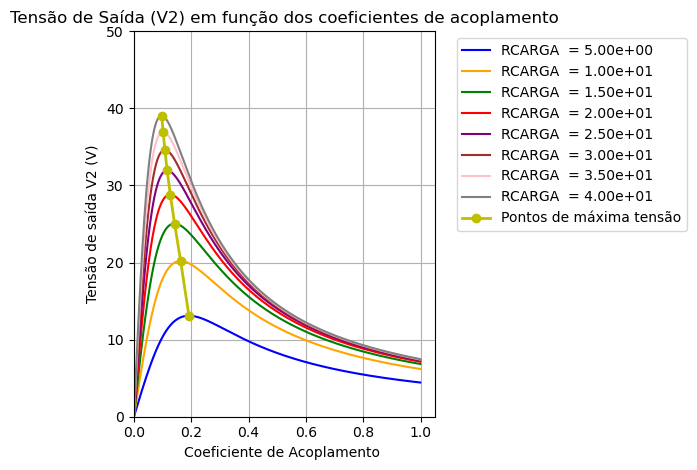

In [431]:
#Declaração de Parâmetros 


fig, ax1 = plt.subplots()

resistencias = np.arange(5 , 45 , 5)
coeficientes = np.arange(0 , 1 , 0.001)
i = 0 
cores = [
    'blue',    # R carga = 5 Ω
    'orange',  # R carga = 10 Ω
    'green',   # R carga = 15 Ω
    'red',     # R carga = 20 Ω
    'purple',  # R carga = 25 Ω
    'brown',   # R carga = 30 Ω
    'pink',    # R carga = 35 Ω
    'gray',    # R carga = 40 Ω
    'yellow',  # Pontos de máxima tensão
]

#Indutâncias 

L1 = indutancia_ressonante(f, C)
L2 = indutancia_ressonante(f, C)
R1, R2 = R_pelicular(Rdc, f)

ZC1, ZL1, ZR1 = impedancia(R1, C, L1, f)
ZC2, ZL2, ZR2 = impedancia(R2, C, L2, f)
Uf = 12 * (2/pi)

v_max = []
k_max = []
pot_max = []

i = 0 

for resistencia in resistencias: 
    
    tensoes = []
    potencias = []
    
    for k in coeficientes: 
        ZM = impedancia_ZM(L1 , L2 , k , f)
        i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorParalelo(ZR1, ZR2, resistencia, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
        tensoes.append(V2)
        potencias.append(P_res)
    max_tensao = max(tensoes)
    max_pot = potencias[tensoes.index(max_tensao)]
    max_k = coeficientes[tensoes.index(max_tensao)]
    
    v_max.append(max(tensoes))
    k_max.append(max_k)
    pot_max.append(max_pot)
    ax1.plot(coeficientes, tensoes, label=f'RCARGA  = {resistencia:.2e}', color=cores[i], linestyle=linestyles[0]) 
    
    i += 1     

ax1.plot(k_max, v_max, label='Pontos de máxima tensão', color='#BFBF00', marker='o', linestyle='-', linewidth=2)
ax1.set_title("Tensão de Saída (V2) em função dos coeficientes de acoplamento")
ax1.set_xlabel("Coeficiente de Acoplamento ")
ax1.set_ylabel("Tensão de saída V2 (V)")
ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax1.set_xlim(0, 1.05)
ax1.set_ylim(0, 50)
ax1.grid(True)

# Ajustar layout para não sobrepor elementos
plt.tight_layout()

# Exibir gráfico
plt.show()

In [432]:
print(v_max)
print(k_max)
print(pot_max)

[13.102254169832275, 20.202204198716068, 25.05628958094152, 28.829377651237724, 31.952078152650152, 34.62911901184602, 36.975724368550445, 39.064798986553036]
[0.192, 0.163, 0.14200000000000002, 0.127, 0.116, 0.108, 0.10200000000000001, 0.097]
[17.166906433088723, 20.406452724331054, 20.927254918799953, 20.77832539394213, 20.418705965461264, 19.986264725609928, 19.5314884654145, 19.07573149824744]


<h3> Segundo as Especificações, temos que o Dispositivo Funciona de 2 a 5W, então vamos calcular a resistência que permite isso
</h3> 

In [433]:
potencia = pot_max[1]
tensão = v_max[1]
R_escolhida = tensão**2 / potencia

print(f'O valor ideal de Resistência desejado é de {R_escolhida}')

O valor ideal de Resistência desejado é de 20.0


d) Calcule as correntes $i_1$ e $i_2$ para três condições de carga ($R_C=1M\Omega$, $R_C=100\Omega$ e $R_C=1\Omega$). Assim que calcular as correntes, calcule também $V_2$ para cada resistor de carga (analise o circuito para saber como calculá-la). Por fim, calcule as relações $N_1/N_2$, $e_1/e_2$ e $V_1/V_2$ e, o mais importante: calcule as potências no primário ($S1$) e no secundário ($S2$).

IMPORTANTE: para dar print nas relações $N_1/N_2$, $V_1/V_2$ e $e_1/e_2$, você precisará usar o **módulo dos fasores**. Para calcular o módulo de um número complexo, use "np.abs(número complexo)".

1948.5


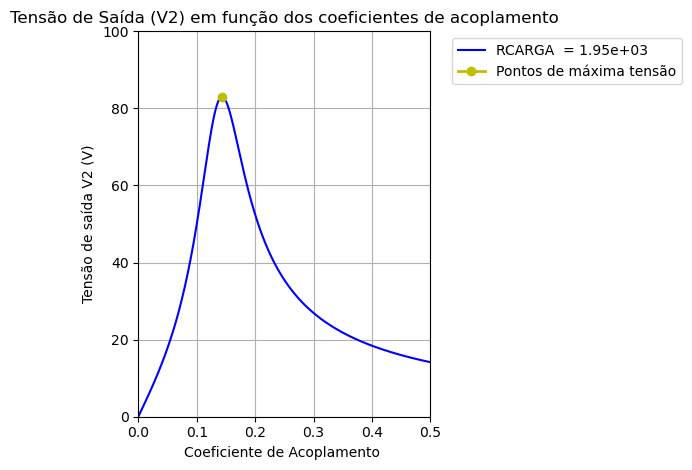

In [434]:
#Declaração de Parâmetros 


fig, ax1 = plt.subplots()

resistencias = np.arange(5 , 45 , 5)
coeficientes = np.arange(0 , 1 , 0.001)
i = 0 
cores = [
    'blue',    # R carga = 5 Ω
    'orange',  # R carga = 10 Ω
    'green',   # R carga = 15 Ω
    'red',     # R carga = 20 Ω
    'purple',  # R carga = 25 Ω
    'brown',   # R carga = 30 Ω
    'pink',    # R carga = 35 Ω
    'gray',    # R carga = 40 Ω
    'yellow',  # Pontos de máxima tensão
]

#Indutâncias 

# L1 = indutancia_ressonante(f, C)
# L2 = indutancia_ressonante(f, C)
L1 = 25e-6
L2 = 25e-6
Rdc = 0.2
R1, R2 = R_pelicular(Rdc, f)

ZC1, ZL1, ZR1 = impedancia(R1, C, L1, f)
ZC2, ZL2, ZR2 = impedancia(R2, C, L2, f)
Uf = 12 * (2/pi)

v_max = []
k_max = []
pot_max = []

i = 0 

tensoes = []
potencias = []

resistencia, _ = R_pelicular(1299, f)
print(resistencia) 
for k in coeficientes: 
    ZM = impedancia_ZM(L1 , L2 , k , f)
    i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorParalelo(ZR1, ZR2, resistencia, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
    tensoes.append(V2)
    potencias.append(P_res)
max_tensao = max(tensoes)
max_pot = potencias[tensoes.index(max_tensao)]
max_k = coeficientes[tensoes.index(max_tensao)]

v_max.append(max(tensoes))
k_max.append(max_k)
pot_max.append(max_pot)
ax1.plot(coeficientes, tensoes, label=f'RCARGA  = {resistencia:.2e}', color=cores[i], linestyle=linestyles[0]) 

i += 1     

ax1.plot(k_max, v_max, label='Pontos de máxima tensão', color='#BFBF00', marker='o', linestyle='-', linewidth=2)
ax1.set_title("Tensão de Saída (V2) em função dos coeficientes de acoplamento")
ax1.set_xlabel("Coeficiente de Acoplamento ")
ax1.set_ylabel("Tensão de saída V2 (V)")
ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax1.set_xlim(0, 0.5)
ax1.set_ylim(0, 100)
ax1.grid(True)

# Ajustar layout para não sobrepor elementos
plt.tight_layout()

# Exibir gráfico
plt.show()

In [435]:
v_max

[82.97703245389481]

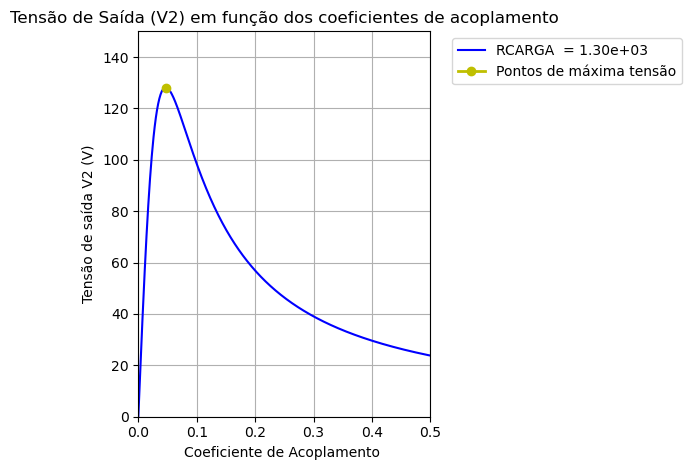

In [436]:
#Declaração de Parâmetros 


fig, ax1 = plt.subplots()

resistencias = np.arange(5 , 45 , 5)
coeficientes = np.arange(0 , 1 , 0.001)
i = 0 
cores = [
    'blue',    # R carga = 5 Ω
    'orange',  # R carga = 10 Ω
    'green',   # R carga = 15 Ω
    'red',     # R carga = 20 Ω
    'purple',  # R carga = 25 Ω
    'brown',   # R carga = 30 Ω
    'pink',    # R carga = 35 Ω
    'gray',    # R carga = 40 Ω
    'yellow',  # Pontos de máxima tensão
]

#Indutâncias 

L1 = indutancia_ressonante(f, C)
L2 = indutancia_ressonante(f, C)
R1, R2 = R_pelicular(Rdc, f)

ZC1, ZL1, ZR1 = impedancia(R1, C, L1, f)
ZC2, ZL2, ZR2 = impedancia(R2, C, L2, f)
Uf = 12 

v_max = []
k_max = []
pot_max = []

i = 0 


    
tensoes = []
potencias = []

resistencia = 1300
for k in coeficientes: 
    ZM = impedancia_ZM(L1 , L2 , k , f)
    i1, i2, V2, eficiencia, P_res = CalcularTransformadorCapacitorParalelo(ZR1, ZR2, resistencia, ZC1, ZC2, ZL1, ZL2, ZM, Uf)
    tensoes.append(V2)
    potencias.append(P_res)
max_tensao = max(tensoes)
max_pot = potencias[tensoes.index(max_tensao)]
max_k = coeficientes[tensoes.index(max_tensao)]

v_max.append(max(tensoes))
k_max.append(max_k)
pot_max.append(max_pot)
ax1.plot(coeficientes, tensoes, label=f'RCARGA  = {resistencia:.2e}', color=cores[i], linestyle=linestyles[0]) 

i += 1     

ax1.plot(k_max, v_max, label='Pontos de máxima tensão', color='#BFBF00', marker='o', linestyle='-', linewidth=2)
ax1.set_title("Tensão de Saída (V2) em função dos coeficientes de acoplamento")
ax1.set_xlabel("Coeficiente de Acoplamento ")
ax1.set_ylabel("Tensão de saída V2 (V)")
ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax1.set_xlim(0, 0.5)
ax1.set_ylim(0, 150)
ax1.grid(True)

# Ajustar layout para não sobrepor elementos
plt.tight_layout()

# Exibir gráfico
plt.show()

In [437]:
v_max

[128.1236116861962]